# $$\text{Credit Risk Dataset}$$
## $$\text{Kevin Milli}$$

--- 
## Introduction
Ho scelto un problema importante su cui lavorare, iniziando questa ricerca facendo "zapping" tra i vari dataset di kaggle, mi sono imbattuto in [Cridit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).

I rischi di credito sono un fenomeno comunemente osservato in aree della finanza che riguardano mutui, carte di credito e altri tipi di prestiti. C'è sempre una probabilità che il mutuatario non restituisca l'importo. Tradizionalmente, si riferisce al rischio che un prestatore non riceva il capitale e gli interessi dovuti, il che comporta un'interruzione dei flussi di cassa e costi aumentati per la riscossione.<br>
Pertanto, valutare e gestire correttamente il rischio di credito può ridurre la gravità di una perdita.

**Definizione di "credito":**
- Il **credito** è la capacità di prendere in prestito denaro o accedere a beni o servizi con l'intesa che verrà restituito insieme alla somma in seguito.
- **L'affidabilità creditizia** è il modo in cui un prestatore determina il grado di affidabilità del mutuatario, per capire quanto probabilmente gli restituirai i soldi.

---
## Objectve and Goal
L'obbiettivo del progetto è analizzare la variabile `loan_status`. 
Dopo un'analisi dei dati e delle correlazioni esistenti con `loan_status`, sarà condotta la creazione di un algoritmo di ML per determinare quanto sia possibile prevedere la variabile `loan_status` partendo dai dati forniti.

---
## Key Features

- `person_age`: Age of the individual applying for the loan.
- `person_income`: Annual income of the individual.
- `person_home_ownership`: Type of home ownership of the individual.
    - Rent: The individual is currently renting a property.
    - Mortgage: The individual has a mortgage on the property they own.
    - Own: The individual owns their home outright.
    - Other: Other categories of home ownership that may be specific to the dataset.
- `person_emp_length`: Employment length of the individual in years.
- `loan_intent`: The intent behind the loan application.
- `loan_grade`: The grade assigned to the loan based on the creditworthiness of the borrower.
    - A: The borrower has a high creditworthiness, indicating low risk.
    - B: The borrower is relatively low-risk, but not as creditworthy as Grade A.
    - C: The borrower's creditworthiness is moderate.
    - D: The borrower is considered to have higher risk compared to previous grades.
    - E: The borrower's creditworthiness is lower, indicating a higher risk.
    - F: The borrower poses a significant credit risk.
    - G: The borrower's creditworthiness is the lowest, signifying the highest risk.
- `loan_amnt`: The loan amount requested by the individual.
- `loan_int_rate`: The interest rate associated with the loan.
- `loan_status`: Loan status, where 0 indicates non-default and 1 indicates default.
    - 0: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
    - 1: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.
- `loan_percent_income`: The percentage of income represented by the loan amount.
- `cb_person_default_on_file`: Historical default of the individual as per credit bureau records.
    - Y: The individual has a history of defaults on their credit file.
    - N: The individual does not have any history of defaults.
- `cb_preson_cred_hist_length`: The length of credit history for the individual.

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib


import warnings
warnings.filterwarnings('ignore') # ignore harmeless warnings

# Visual Purpose
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set() # darkgrid

In [4]:
def split_data(X, y, test_size=0.4, val_size=0.5, random_state=42):
    """
    La funzione split_data è stata progettata per semplificare 
    il processo di suddivisione di un dataset in tre parti: 
    set di addestramento, set di convalida e set di test.
    
    Metodo : StratifiedShuffleSplit
    
    Parametri:

        X: Il DataFrame delle caratteristiche (features) il dataset da suddividere.
        y: La Serie o array delle etichette (labels) corrispondenti alle caratteristiche nel dataset.
        test_size (default=0.4): La proporzione del dataset da allocare come set di test.
        val_size (default=0.5): La proporzione del set di test da allocare come set di convalida.
        random_state (default=42): Il seed per la riproducibilità della suddivisione dei dati.
        
    Output: X_train, X_val, X_test, y_train, y_val, y_test
    """
    splitter = StratifiedShuffleSplit(random_state=random_state, test_size=test_size, n_splits=1)
    
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    splitter2 = StratifiedShuffleSplit(random_state=random_state, test_size=val_size, n_splits=1)
    
    for train_idx, val_idx in splitter2.split(X_test, y_test):
        X_test, X_val = X_test.iloc[train_idx], X_test.iloc[val_idx]
        y_test, y_val = y_test.iloc[train_idx], y_test.iloc[val_idx]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

**Data**

In [5]:
df = pd.read_csv('credit_risk_dataset.csv')

In [6]:
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

## Feature Engineering

### Dealing with Outliers

**Years of Work**

In [7]:
df[df['person_emp_length']>100]

person_age  person_income person_home_ownership  person_emp_length  \
0            22          59000                  RENT              123.0   
210          21         192000              MORTGAGE              123.0   

    loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0      PERSONAL          D      35000          16.02            1   
210     VENTURE          A      20000           6.54            0   

     loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                   0.59                         Y                           3  
210                 0.10                         N                           4

**Data Imputation:**

Considering that the above data regarding employment length seems unrealistic, I assume that this data can be inferred from a correlation between `person_income` (individual income) and `loan_amnt` (loan amount requested). The underlying idea stems from the assumption that with increasing age, individuals tend to request smaller loans, seeking stability over hypothetical risk. Hence, I decided to impute the data based on the correlation between these two columns.


In [8]:
# Customer index 0

C0 = df[(df['person_income']>50000) & (df['person_income']<69000)]

mean_for_c0 = float(int(C0[(C0['loan_amnt']>30000) & (C0['loan_amnt']<40000)].iloc[1:,:]['person_emp_length'].mean()))
mean_for_c0

7.0

In [9]:
df.loc[0,'person_emp_length'] = mean_for_c0

In [10]:
# Customer index 210

C210 = df[(df['person_income']>180000) & (df['person_income']<200000)]
C210 = C210[(C210['loan_amnt']>15000) & (C210['loan_amnt']<25000)]
mean_for_c210 = float(int(C210[C210.index!=210]['person_emp_length'].mean()))
mean_for_c210

7.0

In [11]:
df.loc[210,'person_emp_length'] = mean_for_c210

**Age**

In [12]:
df.person_age.unique()

array([ 22,  21,  25,  23,  24,  26, 144, 123,  20,  32,  34,  29,  33,
        28,  35,  31,  27,  30,  36,  40,  50,  45,  37,  39,  44,  43,
        41,  46,  38,  47,  42,  48,  49,  58,  65,  51,  53,  66,  61,
        54,  57,  59,  62,  60,  55,  52,  64,  70,  78,  69,  56,  73,
        63,  94,  80,  84,  76,  67], dtype=int64)

Controllando le età mi sono accorto che ci sono altri tre errori, provvedo a rimuoverli dal dataframe.

In [13]:
# rimuovo gli outliers
df = df[~df['person_age'].isin([144, 123, 94])]

In [14]:
max_age = df['person_age'].max()
min_age = df['person_age'].min()
print(f"Age Between: {min_age} - {max_age}\n")

# people with an age between min and max 
def age_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = df['person_age'].between(next, arr[i+1]).sum()
        print(f'Age between {next} and {arr[i+1]} \t Number of people: {num_people}')
        
age_group([0 ,19, 26, 36, 46, 56, 69, 79, 84])

Age Between: 20 - 84

Age between 1 and 19 	 Number of people: 0
Age between 20 and 26 	 Number of people: 17829
Age between 27 and 36 	 Number of people: 11834
Age between 37 and 46 	 Number of people: 2360
Age between 47 and 56 	 Number of people: 434
Age between 57 and 69 	 Number of people: 104
Age between 70 and 79 	 Number of people: 12
Age between 80 and 84 	 Number of people: 2


### Dealing With Missing Values

In [15]:
null_ = df.isnull().sum()
null_[null_>0]

person_emp_length     895
loan_int_rate        3114
dtype: int64

Interest Rate Calculation:

The formula for calculating the interest rate is:
$$
\large \text{Interest Rate} = \frac{\text{(Loan Amount)} \times \text{(Annual Interest Rate)} \times \text{(Number of Years)}}{100}
$$

Where:

- `Loan Amount` is the sum of money being borrowed.
- `Annual Interest Rate` is the annual percentage of interest applied to the loan.
- `Number of Years` represents the period of time for loan repayment in years.

**Note:**

I did not opt to create Machine Learning models to fill in the `Null` variables because:

Initially, I chose to attempt removal, and if the model did not meet certain criteria, I would have reverted and filled in the values. However, this was not necessary in this case.


In [16]:
# rimozione dei dati nulli 
print(df.shape)
df = df.dropna()
print(df.shape)

(32575, 12)
(28634, 12)


## Exploratory Data Analysis (EDA)

In [17]:
# general description
df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  28634.000000   2.863400e+04       28634.000000  28634.000000   
mean      27.711706   6.643063e+04           4.780471   9656.577845   
std        6.171993   5.155102e+04           4.035518   6329.645284   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.946200e+04           2.000000   5000.000000   
50%       26.000000   5.590000e+04           4.000000   8000.000000   
75%       30.000000   8.000000e+04           7.000000  12500.000000   
max       84.000000   2.039784e+06          41.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   28634.000000  28634.000000         28634.000000   
mean       11.039718      0.216631             0.169501   
std         3.229540      0.411956             0.106387   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.480000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                28634.000000  
mean                     5.793392  
std                      4.037040  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

In [93]:
sns.countplot(x='loan_status', data=df)
plt.title('Loan Count by Status')
plt.xlabel('Loan Status')
plt.ylabel('Number of Loans')
plt.xticks([0,1],['Non Default', 'Default'])
plt.show()

In [92]:
count = df['loan_status'].value_counts()
labels = ['Non Default', 'Default']
colors = ['#ff9999', '#66b3ff']

explode = (0, 0.1)  # "Default" slice

# Pie Chart
plt.pie(count, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

# Creating a white circle at the center --> donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Total occurrences
total = sum(count)

# Total at the center of the pie
plt.text(0, 0, f'Total:\n{total}', ha='center', va='center', fontsize=12, fontweight='bold')

plt.title('Loan Count by Status')
plt.axis('equal')  # To maintain circular aspect ratio
plt.show()

From this graph, we can observe that we have an imbalanced `target` variable.

**Years of Work**

In [20]:
plt.figure(figsize=(12,4), dpi=150)
sns.boxplot(x=df["person_emp_length"])
plt.title('Distribution of Years of Work')
plt.xticks(list(range(0,45,5)))
plt.show()

In [91]:
plt.figure(figsize=(12,5), dpi=150)
sns.histplot(data=df, x='person_emp_length', binwidth=1, kde=True)
plt.axvline(df.person_emp_length.mean(), color='red', linestyle=':', label='$\mu$', linewidth=2)
plt.axvline(df.person_emp_length.mode()[0], color='green', linestyle=':', label='mode', linewidth=2)

plt.title('Distribution of years of work')
plt.ylabel('Number of customers', labelpad=15)

plt.xlabel('Years of work', labelpad=15)
plt.xticks(ticks=list(range(0,25)))
plt.xlim([-.25, 25])
plt.legend()
plt.show()

# Limito i valori al 25* anno perchè la distribuzione non è piu visibile da un certo punto in poi

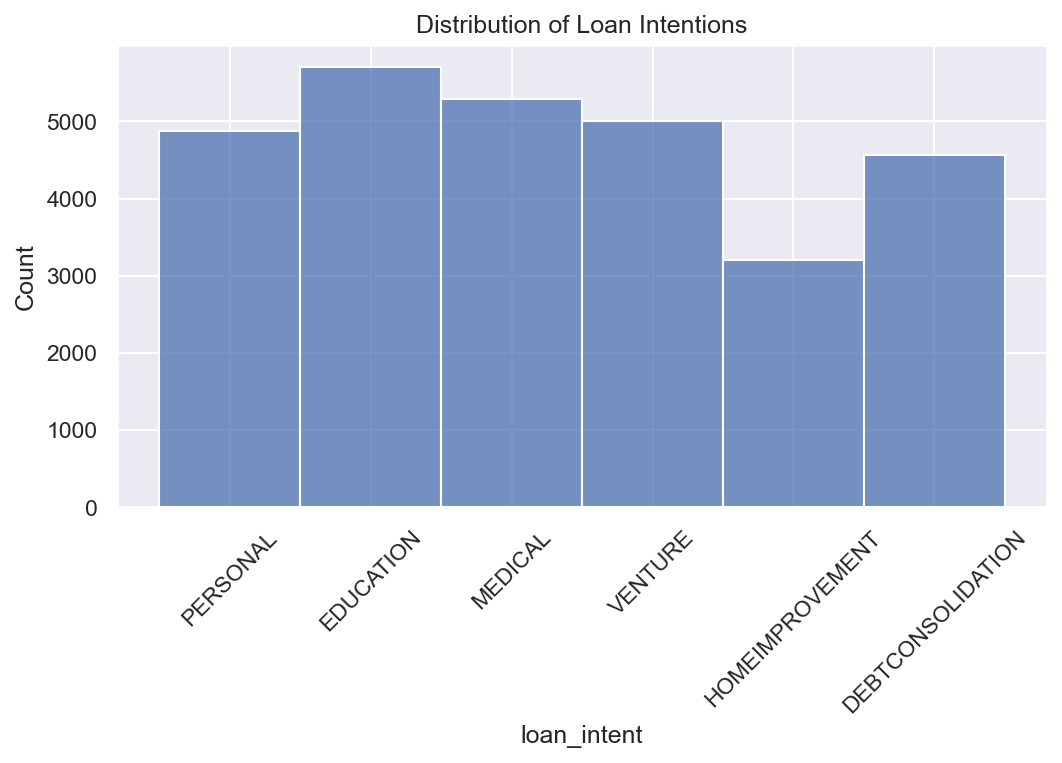

In [22]:
plt.figure(figsize=(8,4), dpi=150)
sns.histplot(data=df, x='loan_intent')
plt.xticks(rotation=45)
plt.title('Distribution of Loan Intentions')
plt.show()

In [23]:
col = ['loan_int_rate','loan_amnt','person_emp_length', 'cb_person_default_on_file']
df[col].groupby('cb_person_default_on_file').describe().T.round(2)

cb_person_default_on_file         N         Y
loan_int_rate     count    23531.00   5103.00
                  mean        10.29     14.51
                  std          2.98      1.73
                  min          5.42     10.28
                  25%          7.66     13.23
                  50%         10.37     14.26
                  75%         12.18     15.60
                  max         21.74     23.22
loan_amnt         count    23531.00   5103.00
                  mean      9537.74  10204.57
                  std       6197.78   6879.36
                  min        500.00    750.00
                  25%       5000.00   5000.00
                  50%       8000.00   8500.00
                  75%      12000.00  14500.00
                  max      35000.00  35000.00
person_emp_length count    23531.00   5103.00
                  mean         4.84      4.52
                  std          4.05      3.96
                  min          0.00      0.00
                  25%          2.00      2.00
                  50%          4.00      4.00
                  75%          7.00      7.00
                  max         41.00     34.00

`Default:` an interest requested whose funds have not been fully repaid.

With this table, I am interested in knowing the difference in `interest rates` for individuals who have defaulted compared to those who have not.

#=========== CONTENT =================#

We observe changes in the `interest rate` when considering the mean, which increases, and the standard deviation, which decreases. This suggests that for those who have defaulted, the creditor had already set a higher interest rate percentage, which is a positive sign. Otherwise, it would have warranted further analysis.

Individuals who default typically have shorter employment lengths and request higher loan amounts compared to those who do not default.


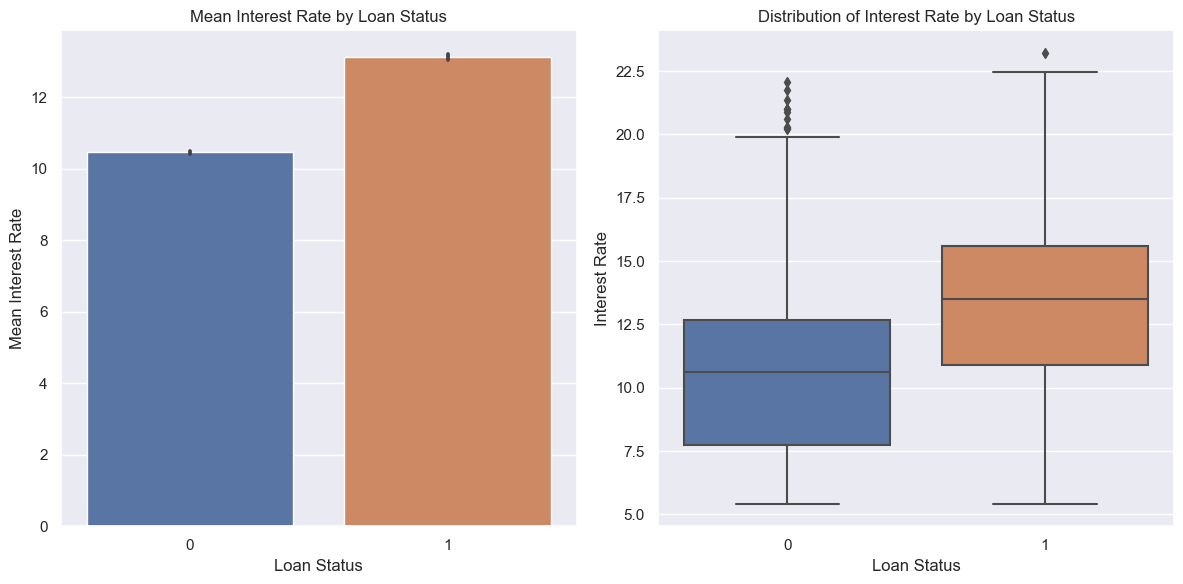

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Descriptive statistics for the interest rate (loan_int_rate)
sns.barplot(x='loan_status', y='loan_int_rate', data=df, ax=ax[0])
ax[0].set_title('Mean Interest Rate by Loan Status')
ax[0].set_xlabel('Loan Status')
ax[0].set_ylabel('Mean Interest Rate')

# Trends in interest rates (loan_int_rate) between default and non-default loans
sns.boxplot(x='loan_status', y='loan_int_rate', data=df, ax=ax[1])
ax[1].set_title('Distribution of Interest Rate by Loan Status')
ax[1].set_xlabel('Loan Status')
ax[1].set_ylabel('Interest Rate')

plt.tight_layout()
plt.show()

In the first graph, it is evident that a higher interest rate is naturally requested for accounts that have defaulted. In the second graph, we observe some outliers, but honestly, they are of little significance for our analysis.

**Loan Grade**

The term `loan grade` refers to a classification or rating assigned to a loan or bond issued by a lender or issuer. This classification is used to assess the risk associated with the loan or bond and to determine the interest rate or yield that should be offered to investors.

#====== THE SEVEN CATEGORIES ========#

**A:** This category typically represents loans with the lowest risk, gradually descending to <br>
**G:** which are loans with the highest risk.

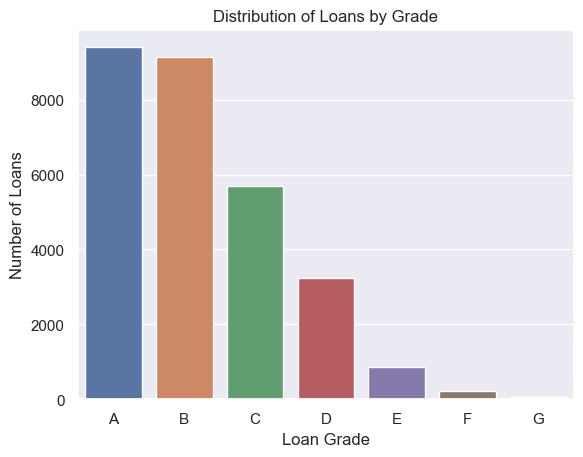

In [87]:
sns.countplot(x='loan_grade', data=df.sort_values('loan_grade'))
plt.title('Distribution of Loans by Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Number of Loans')
plt.show()

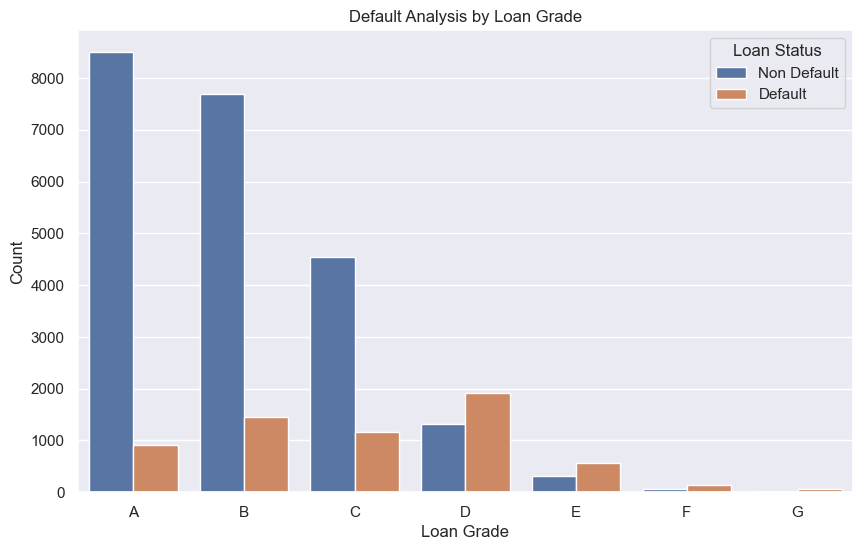

In [94]:
# Analyzing default based on loan grade
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_grade', hue='loan_status', data=df.sort_values('loan_grade'))
plt.title('Default Analysis by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right', labels=['Non Default', 'Default'])
plt.show()

As expected, the most significant `defaults` are associated with the riskier investments. Specifically, from grade `D` onwards, we observe an unfavorable disparity.


**Person Income**

In [96]:
plt.figure(figsize=(12,4), dpi=150)
sns.boxplot(x=df["person_income"])
plt.title('Distribution of Annual Income')
plt.show()

In [95]:
plt.figure(figsize=(12,6), dpi=150)
sns.histplot(df['person_income'], bins=300, kde=True)
plt.axvline(df.person_income.mean(), color='red', linestyle=':', label='$\mu$', linewidth=2)
plt.axvline(df.person_income.median(), color='green', linestyle=':', label='Median', linewidth=2)
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income', labelpad=15)
plt.ylabel('Number of People', labelpad=15)
plt.xlim([0, .4e6]) # limit data for visual purpose
plt.legend()
plt.show()

**Loan Interest Rate**

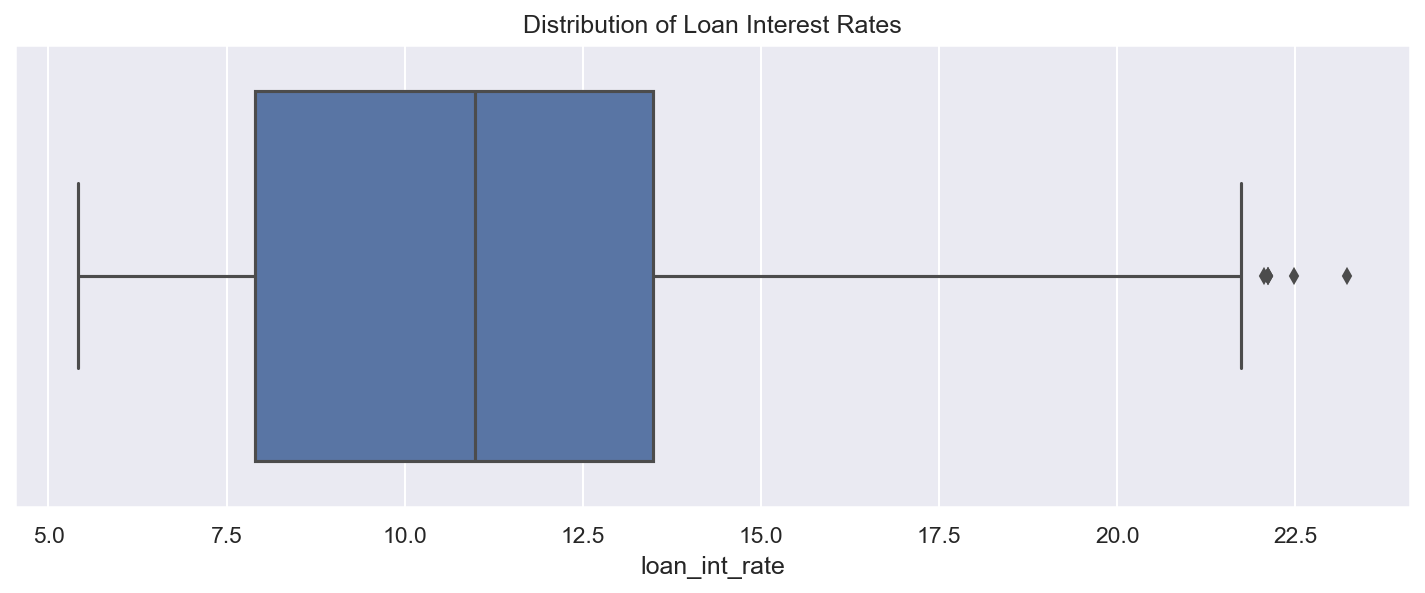

In [29]:
plt.figure(figsize=(12,4), dpi=150)
sns.boxplot(x=df["loan_int_rate"])
plt.title('Distribution of Loan Interest Rates')
plt.show()

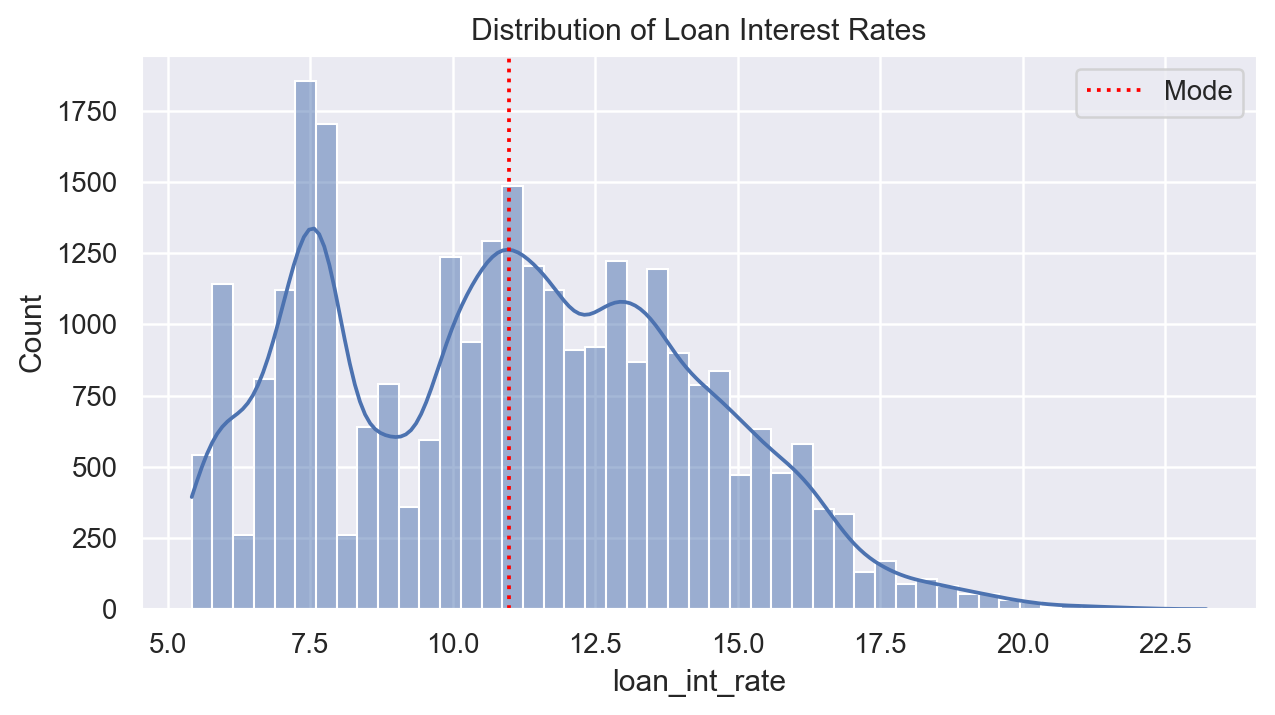

In [32]:
plt.figure(figsize=(8,4), dpi=180)
sns.histplot(data=df, x='loan_int_rate', kde=True)
plt.axvline(df.loan_int_rate.mode()[0], color='red', linestyle=':', label='Mode')
plt.title('Distribution of Loan Interest Rates')
plt.legend()
plt.show()

**Loan Percent Income**

In [34]:
plt.figure(figsize=(12,4), dpi=150)
sns.boxplot(x=df["loan_percent_income"])
plt.title('Distribution of Loan Percentage of Income')
plt.show()

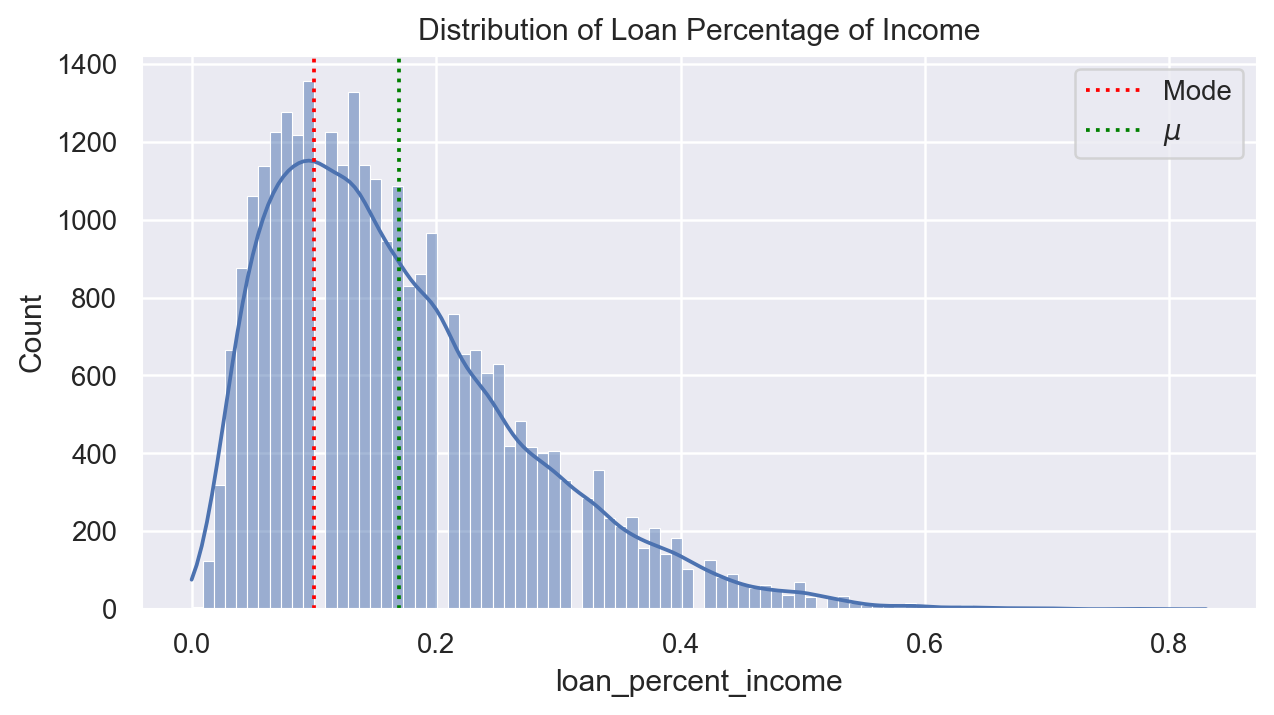

In [35]:
plt.figure(figsize=(8,4), dpi=180)
sns.histplot(data=df, x='loan_percent_income', kde=True)
plt.title('Distribution of Loan Percentage of Income')
plt.axvline(df.loan_percent_income.mode()[0], color='red', linestyle=':', label='Mode')
plt.axvline(df.loan_percent_income.mean(), color='green', linestyle=':', label='$\mu$')
plt.legend()
plt.show()

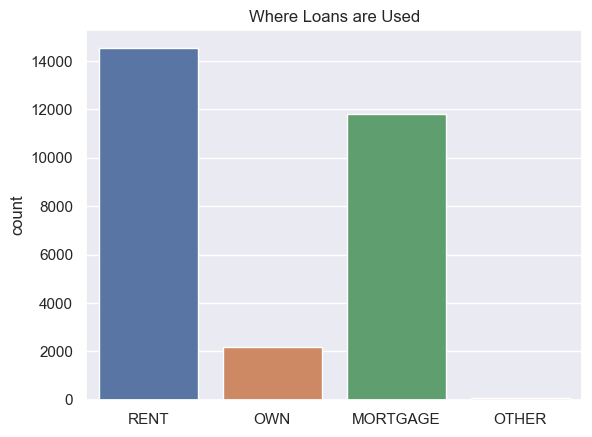

In [36]:
sns.countplot(data=df, x='person_home_ownership')
plt.title('Where Loans are Used')
plt.xlabel("")
plt.show()

In [37]:
plt.figure(figsize=(14,5), dpi=200)
sns.barplot(data=df,  x='loan_intent', y='person_income', hue='person_home_ownership')
plt.xlabel('Loan Intent', labelpad=10)
plt.ylabel('Person Income', labelpad=10)
plt.title('Personal Income Based on Loan Intent and Home Ownership Type')
plt.show()

In [38]:
sns.pairplot(data=df, hue='loan_status')

This is one of the most important graphs, clearly illustrating which variables will be most separable during the modeling phase. There are no linear relationships between the variables, and the scatter plots suggest that models performing well on this dataset will be ensemble methods or methods based on the Kernel-rbf. Spatial separation potential can be discerned in some graphs, indicating that the ML model may perform well.

In [39]:
corr_matrix = df.corr(method = "pearson", numeric_only=True)

corr_matrix.style.background_gradient(cmap='coolwarm')

**Dummie Variables**

In [40]:
# I save the numerical columns and divide the categorical ones into two lists:

num = [i for i in df.columns if df[i].dtype == np.int64 or df[i].dtype == np.float64]
obj = [i for i in df.columns if df[i].dtype == np.object_]

In [41]:
print(obj)
print("")
print(num)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']


In [42]:
df_dummies = pd.get_dummies(df[obj], drop_first=True, dtype=int)
df_numb = df[num]

ddf = pd.concat([df_dummies, df_numb], axis=1)

In [43]:
plt.figure(figsize=(14,10), dpi=180)
ddf_corr = ddf.corr()['loan_status'].sort_values(ascending=False)[1:]
sns.heatmap(ddf.corr(), annot=True, cmap="Spectral", fmt='.2f')

<Axes: >

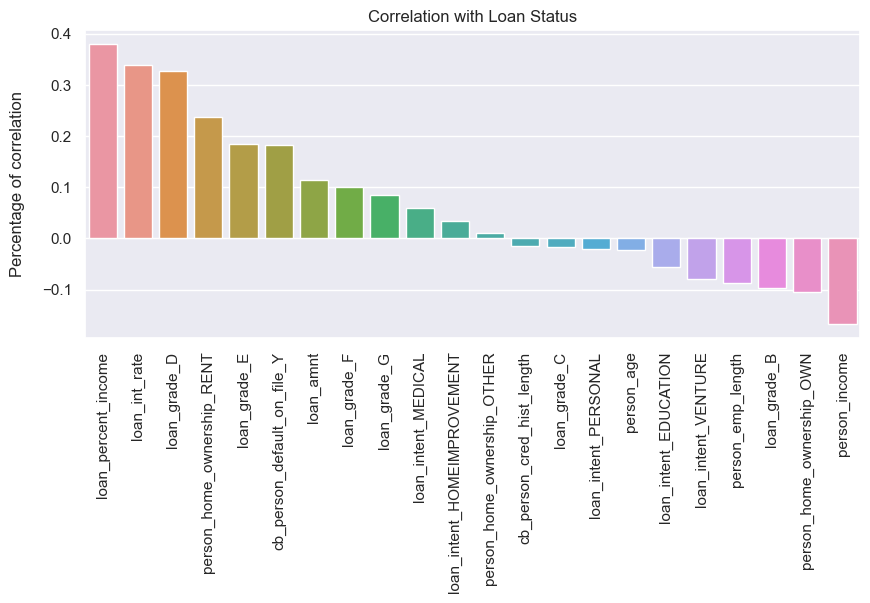

In [44]:
plt.figure(figsize=(10,4))
sns.barplot(x=ddf_corr.index, y=ddf_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Loan Status")
plt.ylabel("Percentage of correlation", labelpad=12);

## Data Preprocessing

In [45]:
X = ddf.drop('loan_status', axis=1)
y = df['loan_status']

In [46]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

`StratifiedShuffleSplit` is a technique used when one aims to divide a dataset into a train set and a test set randomly while preserving the same class distribution between the two sets. This ensures that both sets reflect the same proportion of positive and negative cases.

In [47]:
print(y_test.value_counts())
print()
print(y_val.value_counts())
print()
print(y_train.value_counts())

loan_status
0    4486
1    1241
Name: count, dtype: int64

loan_status
0    4487
1    1240
Name: count, dtype: int64

loan_status
0    13458
1     3722
Name: count, dtype: int64


### Scaling Data

I employ the `MinMax` metric to mitigate issues with data imbalances and because in model selection, I've chosen models that require data scaling, such as `SVC`.

In [48]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_eval_scaled = scaler.transform(X_val)

## Model Evalueation

In [49]:
def classification_models():
    models = []
    models.append(('RandomForest', RandomForestClassifier(random_state=10)))
    models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=10)))
    models.append(('XGBClassifier', XGBClassifier(random_state=10)))
    models.append(('AdaBoost', AdaBoostClassifier(random_state=10)))
    models.append(('svc', SVC(random_state=10, kernel='rbf')))
    
    return models

models = classification_models()

In [50]:
def model_fit_evaluate(models, X_train, y_train, X_test, y_test):
    # fit
    for model in models:
        print(f"{model[0]}\n")
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        
        # Evaluation
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
    
        # show
        print(f"""
Confusion Matrix:\n{cm}\n
                classification report:\n{cr}\n
{"-"*60}
        """)

In [51]:
model_fit_evaluate(models, X_train_scaled, y_train, X_test_scaled, y_test)

RandomForest


Confusion Matrix:
[[4443   43]
 [ 353  888]]

                classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4486
           1       0.95      0.72      0.82      1241

    accuracy                           0.93      5727
   macro avg       0.94      0.85      0.89      5727
weighted avg       0.93      0.93      0.93      5727


------------------------------------------------------------
        
GradientBoostingClassifier


Confusion Matrix:
[[4408   78]
 [ 375  866]]

                classification report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4486
           1       0.92      0.70      0.79      1241

    accuracy                           0.92      5727
   macro avg       0.92      0.84      0.87      5727
weighted avg       0.92      0.92      0.92      5727


------------------------------------------------------------

La scelta dei modelli ricade su:

1) XGB

2) RandomForest

## Hyperparameter Tuning

### Random Forest

In [281]:
model = RandomForestClassifier(class_weight="balanced")

param_grid = {
    "n_estimators": [90,100,110],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,3],
    "max_depth": [None,10,20,25,30],
    "bootstrap": [True, False]
    
}

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [90, 100, 110]})

In [282]:
best_param1 = grid.best_params_
best_param1

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

In [283]:
model = RandomForestClassifier(class_weight="balanced", **best_param1)

model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2')

In [284]:
feat_imp = pd.DataFrame(data={
    'Feature': scaler.get_feature_names_out(), 
    'Importance': model.feature_importances_}
                       ).sort_values('Importance', ascending=False)

feat_imp[feat_imp['Importance']>.01]

Feature  Importance
20          loan_percent_income    0.201232
19                loan_int_rate    0.158740
16                person_income    0.156735
18                    loan_amnt    0.081751
10                 loan_grade_D    0.060030
2    person_home_ownership_RENT    0.055242
17            person_emp_length    0.054311
15                   person_age    0.050024
21   cb_person_cred_hist_length    0.040992
1     person_home_ownership_OWN    0.017073
4   loan_intent_HOMEIMPROVEMENT    0.015809
14  cb_person_default_on_file_Y    0.015655
9                  loan_grade_C    0.015591
7           loan_intent_VENTURE    0.015210
3         loan_intent_EDUCATION    0.014300
11                 loan_grade_E    0.013407
6          loan_intent_PERSONAL    0.011096
5           loan_intent_MEDICAL    0.010288

In [285]:
y_pred = model.predict(X_eval_scaled)

In [286]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4487
           1       0.97      0.69      0.80      1240

    accuracy                           0.93      5727
   macro avg       0.94      0.84      0.88      5727
weighted avg       0.93      0.93      0.92      5727



In [287]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot(cmap=plt.cm.Blues, values_format='d')
disp.ax_.grid(False);

In [288]:
# Nomi delle feature preprocessate dallo scaler
feature_names = scaler.get_feature_names_out().tolist()

# Modello migliore dalla RandomizedSearchCV
best_model = grid.best_estimator_

# Uno degli alberi dalla foresta
decision_tree = best_model.estimators_[0]

# Plot
f, ax = plt.subplots(1, 1, figsize=(20, 12))

plot_tree(decision_tree, ax=ax, fontsize=9, filled=True, proportion=True, max_depth=3,
          feature_names=feature_names)

plt.show()

### XGBClassifier

In [320]:
model2 = XGBClassifier()

param_grid = {
    "n_estimators": [100, 150, 200, 250],
    "max_depth": [None,5,7,8,10],
    "max_leaves": [1, 2, 3, 4],
    "learning_rate": [.1,.2,.3],
    "subsample": [.5,.6,.7,.8]
}

grid2 = RandomizedSearchCV(estimator=model2, param_distributions=param_grid, n_jobs=-1)
grid2.fit(X_train_scaled, y_train)

[12:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.



RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           class_weight='balanced',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [None, 5, 7, 8, 10],
                                        'max_leaves': [1, 2, 3, 4],
                                        'n_estimators': [100, 150, 200, 250],
                                        'subsample': [0.5, 0.6, 0.7, 0.8]})

In [321]:
best_param2 = grid2.best_params_
best_param2

{'subsample': 0.6,
 'n_estimators': 250,
 'max_leaves': 1,
 'max_depth': None,
 'learning_rate': 0.1}

In [322]:
model2 = XGBClassifier(**best_param2)
model2.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=1,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [323]:
y_pred2 = model2.predict(X_eval_scaled)

In [324]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4487
           1       0.96      0.70      0.81      1240

    accuracy                           0.93      5727
   macro avg       0.94      0.85      0.88      5727
weighted avg       0.93      0.93      0.93      5727



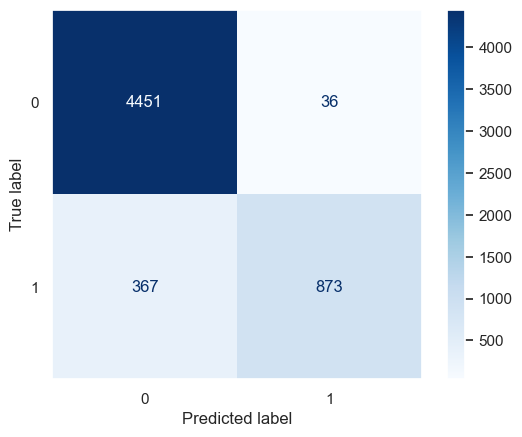

In [325]:
cm = confusion_matrix(y_val, y_pred2)
disp = ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot(cmap=plt.cm.Blues, values_format='d')
disp.ax_.grid(False);

## Final Model: XGBoostClassifier

In [85]:
final_model = XGBClassifier(**best_param2)
final_model.fit(X, y)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_features='log2', min_samples_split=3,
                       n_estimators=50)

In [86]:
# Saving the model to a file
joblib.dump(final_model, 'credit_risk.pkl')

['credit_risk.pkl']

In [ ]:
# To load the model later

# loaded_model = joblib.load('credit_risk.pkl')

## Conclusions

After careful analysis and optimization, I trained a machine learning model that achieved an accuracy of 93% in predicting the default risk in loans. Although the model has demonstrated good ability to identify risky loans, there are still opportunities for further performance improvement. This work provides a solid foundation for financial risk management in lending, enabling more informed and targeted decisions.